# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.

In [5]:
# Setup and import everything
%matplotlib notebook

import datetime
import math
import os
import pandas as pd
import yaml

from processor import analysis, reports

from IPython.display import display

# TODO pasar directorio de reportes por linea de comando o archivo de configuracion
base_directory = os.path.join(os.getcwd(), '/home/gaston/workspace/taller-3/tix/reports-batches/tar-generated/batch-test-report')
with open(os.path.join(base_directory, 'description.yml')) as fp:
    batch_description = yaml.load(fp)
batch_description

{'connection_speed': 1500,
 'experiment': [{'lapse': 3600, 'speed': 1500, 'start': 1513310400},
  {'lapse': 3600, 'speed': 1125, 'start': 1513314000},
  {'lapse': 3600, 'speed': 750, 'start': 1513317600},
  {'lapse': 3600, 'speed': 375, 'start': 1513321200},
  {'lapse': 3600, 'speed': 0, 'start': 1513324800}]}

In [6]:
def get_analyzer_results(reports_batch_dir):
    rh = reports.ReportHandler(os.path.join(base_directory, reports_batch_dir))
    ip, obs_set = rh.get_ip_and_processable_observations()
    if ip is None and obs_set is None:
        raise ValueError('Reports batch directory {} has no reports to use!'.format(reports_batch_dir))
    analyzer = analysis.Analyzer(obs_set)
    results = analyzer.get_results()
    return results

def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    for experiment_configuration in batch_description['experiment']:
        start = experiment_configuration['start']
        lapse = experiment_configuration['lapse']
        if start <= batch_start_time < start + lapse:
            batch_starting_conf = experiment_configuration
        if start <= batch_end_time < start + lapse:
            batch_ending_conf = experiment_configuration
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
    if batch_starting_conf is None and batch_ending_conf is None:
        return None
#         raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
#                                                                                           batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed'] / batch_description['connection_speed']
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed'] / batch_description['connection_speed']
    elif batch_starting_conf['speed'] == batch_ending_conf['speed']:
        expected_usage = batch_starting_conf['speed'] / batch_description['connection_speed']
    else:
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf['start'] + batch_starting_conf['lapse'] - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf['start']
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed'] +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed']) / batch_description['connection_speed']
    return expected_usage
    

In [7]:
columns = ['batch_start_timestamp', 'batch_end_timestamp',
           'batch_start_time', 'batch_end_time',
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage', 'error', 'relative_error']
data = pd.DataFrame(columns=columns)

for reports_batch_dir in sorted(os.listdir(base_directory)):
    reports_batch_dir_path = os.path.join(base_directory, reports_batch_dir)
    if not os.path.isdir(reports_batch_dir_path): continue
    results = get_analyzer_results(reports_batch_dir_path)
    batch_start_time = int(reports_batch_dir)
    batch_end_time = results['timestamp']
    expected_usage = get_expected_usage(batch_start_time, batch_end_time)
    if expected_usage is None: continue
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         datetime.datetime.fromtimestamp(batch_start_time),
                         datetime.datetime.fromtimestamp(batch_end_time),
                         results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                         results['downstream']['quality'], results['downstream']['usage'], 
                         results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                         results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage, 
                         math.fabs(expected_usage - results['downstream']['usage']), 
                         (math.fabs(expected_usage - results['downstream']['usage']) / expected_usage) 
                         if expected_usage != 0 else math.fabs(expected_usage - results['downstream']['usage']))
                       ], 
                       columns=columns)
    data = data.append(df_)
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)

,batch_start_timestamp,batch_end_timestamp,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,upstream_quality,upstream_usage,expected_downstream_usage,error,relative_error
0,1513309492,1513310565,2017-12-15 00:44:52,2017-12-15 01:02:45,0.486913,0.341124,1.0,0.541152,0.516403,0.287884,1.0,0.726337,1.000000,0.458848,0.458848
1,1513310041,1513310851,2017-12-15 00:54:01,2017-12-15 01:07:31,0.514572,0.476698,1.0,0.950530,0.493106,0.482292,1.0,0.950442,1.000000,0.049470,0.049470
2,1513310591,1513311223,2017-12-15 01:03:11,2017-12-15 01:13:43,0.550075,0.294563,1.0,0.853301,0.524611,0.241592,1.0,1.030702,1.000000,0.146699,0.146699
3,1513311149,1513312125,2017-12-15 01:12:29,2017-12-15 01:28:45,0.560597,0.491905,1.0,0.895000,0.506081,0.453233,1.0,1.093812,1.000000,0.105000,0.105000
4,1513311705,1513312655,2017-12-15 01:21:45,2017-12-15 01:37:35,0.508676,0.522759,1.0,1.046875,0.514537,0.545973,1.0,1.031716,1.000000,0.046875,0.046875
5,1513312259,1513312903,2017-12-15 01:30:59,2017-12-15 01:41:43,0.592278,0.388491,1.0,0.973034,0.531599,0.226196,1.0,1.009412,1.000000,0.026966,0.026966
6,1513312815,1513313836,2017-12-15 01:40:15,2017-12-15 01:57:16,0.564955,0.607242,1.0,0.959432,0.485820,0.249746,1.0,1.071575,1.000000,0.040568,0.040568
7,1513313371,1513313993,2017-12-15 01:49:31,2017-12-15 01:59:53,0.516177,0.433728,1.0,0.654206,0.568271,0.545887,1.0,0.817326,1.000000,0.345794,0.345794
8,1513313929,1513314629,2017-12-15 01:58:49,2017-12-15 02:10:29,0.465647,0.652822,1.0,0.530000,0.582194,0.550055,1.0,0.787449,0.775357,0.245357,0.316444
9,1513314485,1513315174,2017-12-15 02:08:05,2017-12-15 02:19:34,0.526151,0.469062,1.0,0.725926,0.544822,0.515133,1.0,0.916045,0.750000,0.024074,0.032099


<IPython.core.display.Javascript object>


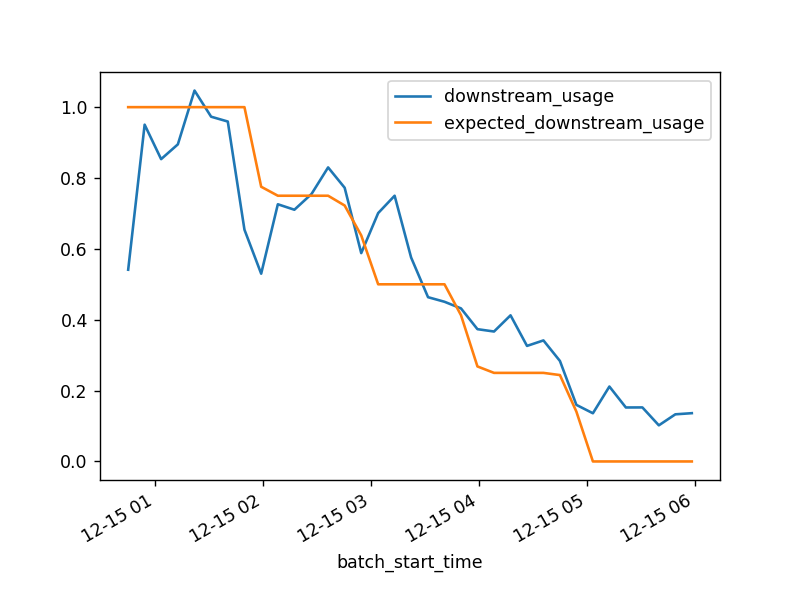

In [8]:
data.plot(x='batch_start_time', y=['downstream_usage', 'expected_downstream_usage'], kind='line')

In [9]:
display(data[['error', 'relative_error']].describe(include='all'))

,error,relative_error
count,35.000000,35.000000
mean,0.113724,0.190173
std,0.098083,0.163095
min,0.004991,0.006655
25%,0.043721,0.071095
50%,0.091615,0.136020
75%,0.149517,0.310490
max,0.458848,0.649770


<IPython.core.display.Javascript object>


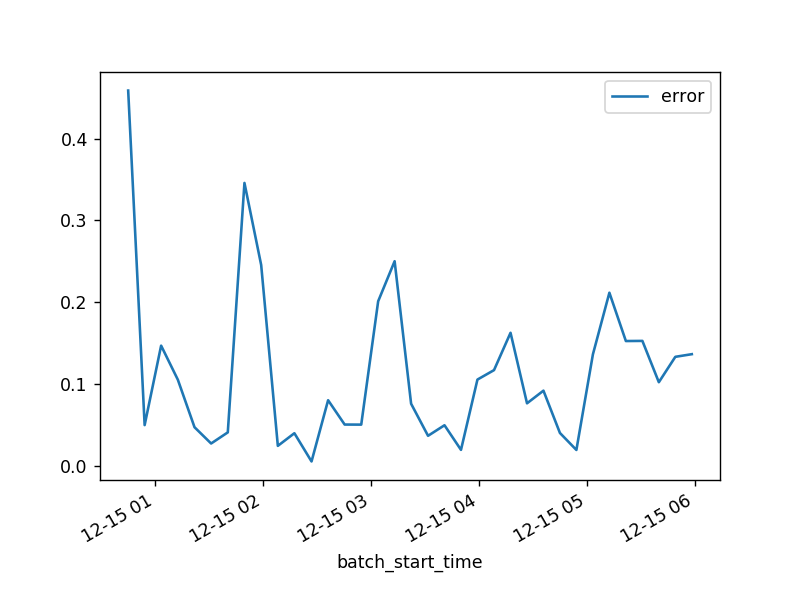

In [10]:
data.plot(x='batch_start_time', y='error', kind='line')

<IPython.core.display.Javascript object>


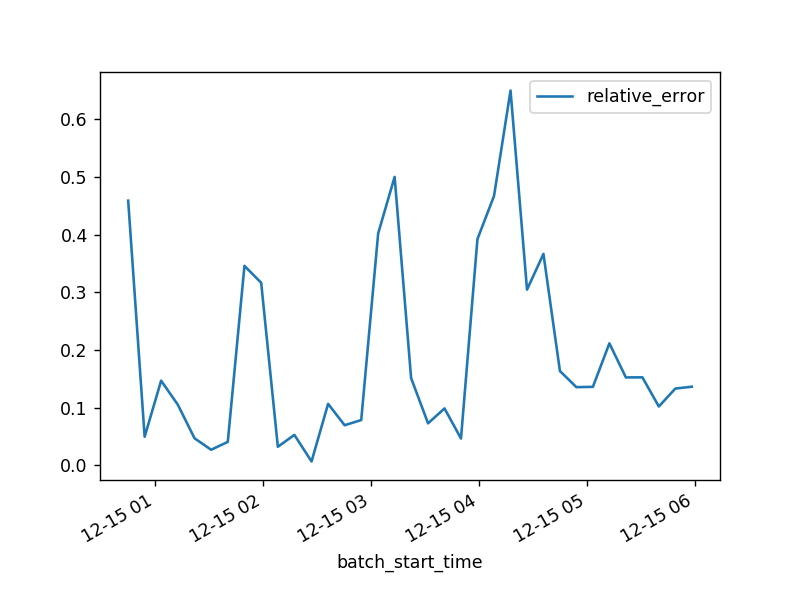

In [11]:
data.plot(x='batch_start_time', y='relative_error', kind='line')